In [1]:
import scanpy as sc
import scanpy.external as sce
import tempfile
import anndata as ad
import os
import torch
import scvi
import ray
import matplotlib.pyplot as plt
from ray import tune
from scvi import autotune
torch.set_float32_matmul_precision('high')
os.chdir("/data")


In [2]:
scvi.__version__

'1.2.0'

In [3]:
torch.cuda.is_available()

True

In [4]:
adata = sc.read_h5ad("h5ad/doublet_filtered.h5ad")

In [5]:
scvi.data.poisson_gene_selection(adata, layer='counts', n_top_genes=7000, subset=True, batch_key="sample_id") # selecting HVGs using poisson sampling

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

Sampling from binomial...:   0%|          | 0/10000 [00:00<?, ?it/s]

In [6]:
model_cls = scvi.model.SCVI
model_cls.setup_anndata(adata, layer="counts", batch_key='sample_id')


In [7]:
model = scvi.model.SCVI(adata, n_layers=2, n_latent=40, n_hidden=256, gene_likelihood="nb")

In [8]:
model.train(early_stopping=True, plan_kwargs={"lr":0.00203546}, check_val_every_n_epoch=1, enable_progress_bar=True, max_epochs =70)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/miniconda3/envs/scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/ubuntu/miniconda3/envs/scanpy/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training:   0%|          | 0/70 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


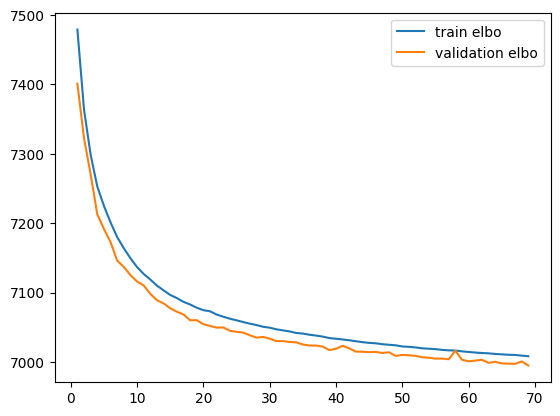

In [9]:
train_elbo = model.history['elbo_train'][1:]
validation_elbo = model.history['elbo_validation'][1:]
#ax = train_elbo.plot()
#validation_elbo.plot(ax=ax)
plt.plot(train_elbo, label="train elbo") 
plt.plot(validation_elbo, label="validation elbo") 
plt.legend()
#plt.savefig("samples_all_notcat_elbo.pdf")

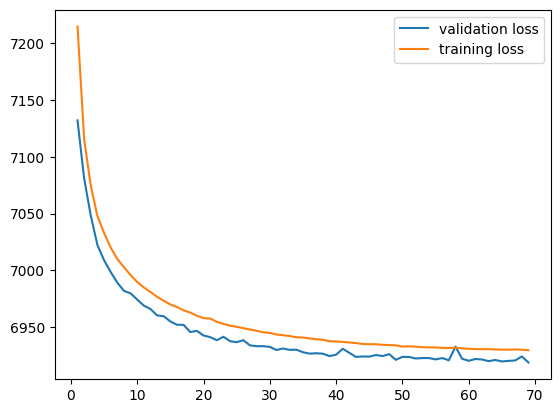

In [10]:
#plt.savefig("samples_all_notcat_elbo.pdf")
#%%
validation_lost = model.history['validation_loss'][1:]
train_loss = model.history['train_loss_epoch'][1:]
plt.plot(validation_lost, label="validation loss") 
plt.plot(train_loss, label="training loss") 
plt.legend()

In [11]:
SCVI_LATENT_KEY = "X_scVI"
adata.obsm[SCVI_LATENT_KEY] = model.get_latent_representation()


In [21]:
sc.pp.neighbors(adata, use_rep=SCVI_LATENT_KEY, n_neighbors=35)
sc.tl.leiden(adata, flavor="igraph", n_iterations=2, resolution=0.5)

In [13]:
SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm[SCVI_LATENT_KEY], accelerator="gpu")

INFO     Using cuda:0 for `pymde.preserve_neighbors`.                                                              


In [19]:
sc.tl.umap(adata, min_dist=0.1)

In [ ]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

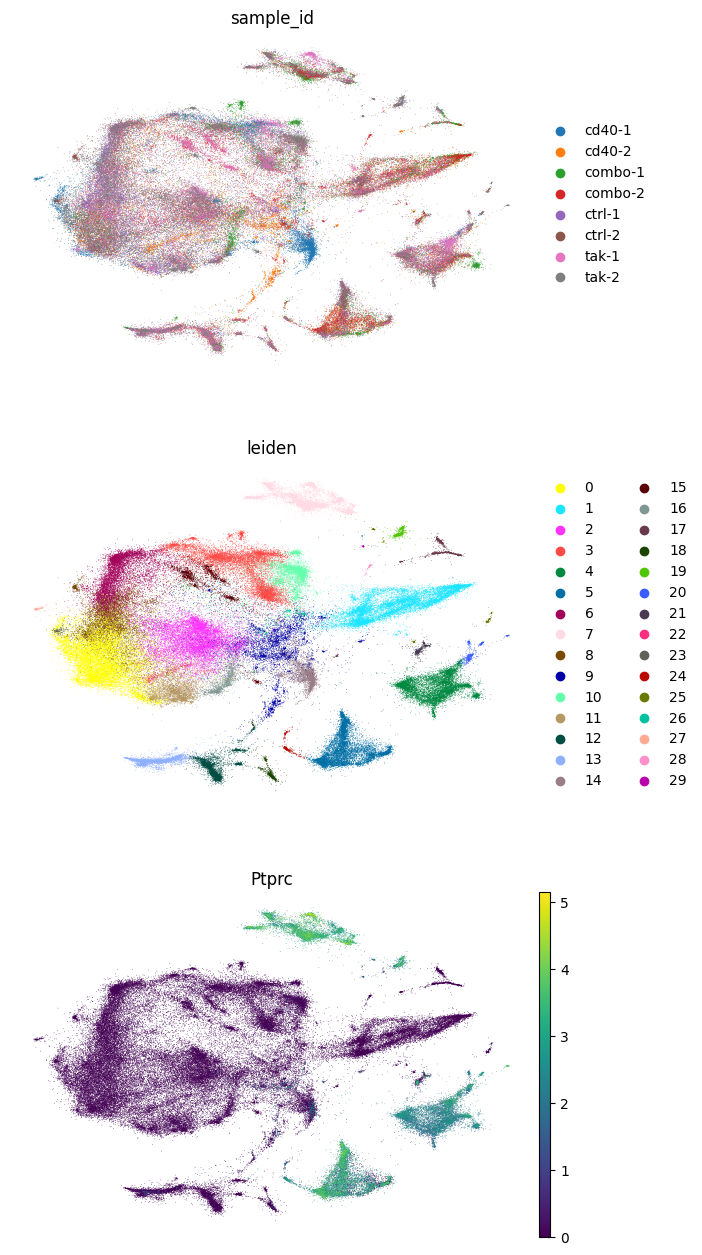

In [18]:
sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["sample_id", "leiden", "Ptprc"],
    frameon=False,
    ncols=1,
    use_raw=False
)

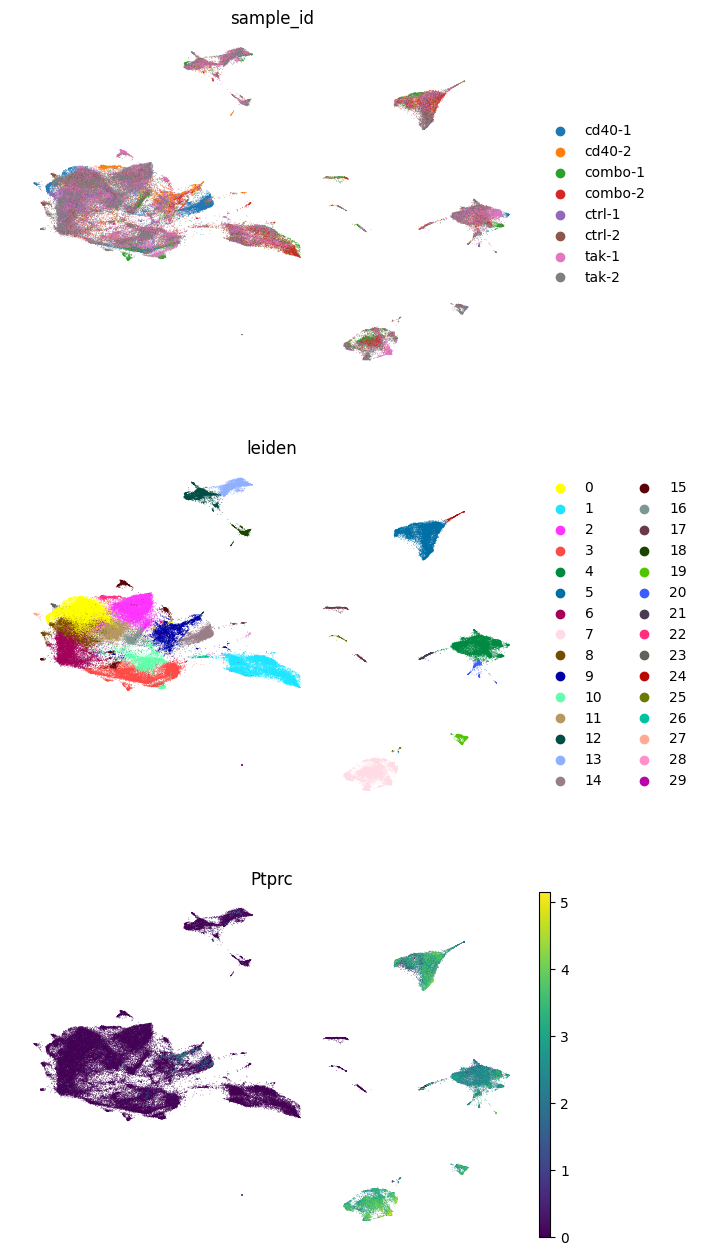

In [20]:
sc.pl.umap(
    adata,
    color=["sample_id", "leiden", "Ptprc"],
    frameon=False,
    ncols=1,
    use_raw=False
)

In [22]:
model.save("h5ad/scvi_model")

In [24]:
adata.X = adata.layers["counts"].copy()
adata.write_h5ad("h5ad/batch_corrected.h5ad")